## Libraries Import

In [71]:
import sys

try:
    from library.synthetic_control import SyntheticControl
except ModuleNotFoundError:
    sys.path.append('/home/jupyter/datasphere')
    from library.synthetic_control import SyntheticControl

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
import pymc as pm
import arviz as az
import causalpy 
import seaborn as sns
from patsy import build_design_matrices, dmatrices

from library.synthetic_control import *
from library.data_generator import generate_gaussian_process_data
from library.synthetic_did import SyntheticDIDModel
from library.synthetic_bayes import WeightedSumFitter


plt.style.use('ggplot')
warnings.filterwarnings("ignore")

## Data generation

In [73]:
N = 10     
T = 100     
T0 = 50       
effect = -20.0 
seed = 42

all_series = generate_gaussian_process_data(N=N, T=T, length_scale=2.0, seed=seed)

all_series[0, :] = all_series[0, :] * 10 + 60

all_series[0, T0:] += effect

np.random.seed(seed)
for i in range(1, N):
    baseline = np.random.uniform(40, 90)
    all_series[i, :] = all_series[i, :] * 10 + baseline
    
df_list = []
for unit_idx in range(N):
    for time_idx in range(T):
        y_val = all_series[unit_idx, time_idx]
        treated_flag = (unit_idx == 0) 
        after_treatment_flag = (time_idx >= T0)
        df_list.append({
            "unit": unit_idx,
            "time": time_idx,
            "y": y_val,
            "treated": treated_flag,
            "after_treatment": after_treatment_flag
        })

data = pd.DataFrame(df_list)

data_bayes = data.pivot(index='time', columns='unit', values='y').reset_index(drop=True).rename_axis(None, axis=1)
data_bayes = data_bayes.rename(columns={0:'actual', 1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i'})

## Frequentist approach

### Synthetic control example

Реализуем следующую модель с добавлением константы:

$$
\min_{\mathbf{w} \in \Delta_J, \alpha} \left\| \mathbf{y}_{\text{pre}}^{\text{tr}} - \alpha - \mathbf{Y}_{\text{pre}}^{\text{co}} \mathbf{w} \right\|_2^2
$$
где $\Delta_J$ обозначает $J$-мерное симплексное множество и оно удовлетворяет условию:

$$\Delta_J = \left\{ \mathbf{w} \in \mathbb{R}^{J} \,\bigg|\, w_j \ge 0, \; \sum_{j=1}^{J} w_j = 1 \right\}
$$

А $\alpha$ представляет собой константу (интерцепт), которая позволяет учитывать постоянное смещение между целевой единицей и контрольными единицами.

Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

Оценка ATT: -18.8496
Веса синтетического контроля:
Индекс: 1, Значение: 0.04
Индекс: 2, Значение: 0.25
Индекс: 4, Значение: 0.05
Индекс: 5, Значение: 0.28
Индекс: 6, Значение: 0.31
Индекс: 7, Значение: 0.08
Индекс: 8, Значение: 0.0


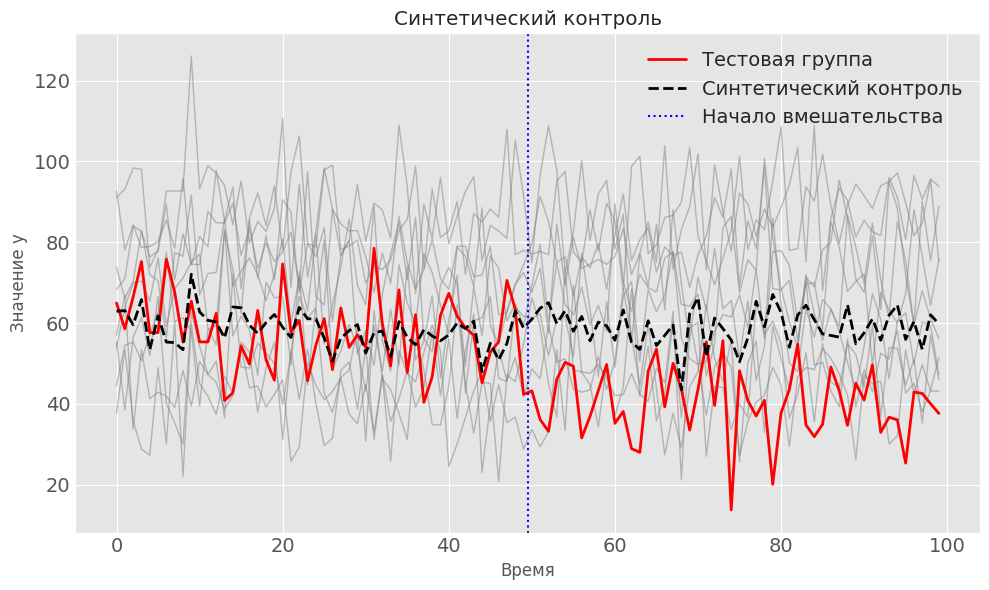

In [75]:
sc_model = SyntheticControl(
    data=data,
    metric="y",
    period_index="time",
    shopno="unit",
    treated="treated",
    after_treatment="after_treatment",
    bootstrap_rounds=1000,
    seed=42,
    intercept=False
)
att_effect = sc_model.synthetic_control()
print("Оценка ATT:", round(att_effect, 4))

sc_model.plot_synthetic_control(T0=50)

### Synthetic DIFF and DIFF example

$$
\hat{w}^{sdid} = \underset{w}{\mathrm{argmin}} \; \left\{ \Bigl\|\bar{{y}}_{pre,tr} - \bigl({Y}_{pre,co} \, {w}_{co} + w_0\bigr)\Bigr\|_2^2 + \zeta^2\, T_{pre}\, \Bigl\|{w}_{co}\Bigr\|_2^2 \right\}
$$

при условии, что $(\sum_i w_i = 1)$ и $(w_i > 0)$ для всех $i$, а также

$$
\zeta = \bigl(N_{tr} \, T_{post}\bigr)^{1/4} \, \sigma(\Delta_{it})
$$

Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

SDID ATT: -17.18
Веса синтетического контроля:
Индекс: 1, Значение: 0.1
Индекс: 2, Значение: 0.13
Индекс: 3, Значение: 0.1
Индекс: 4, Значение: 0.11
Индекс: 5, Значение: 0.11
Индекс: 6, Значение: 0.12
Индекс: 7, Значение: 0.1
Индекс: 8, Значение: 0.12
Индекс: 9, Значение: 0.11


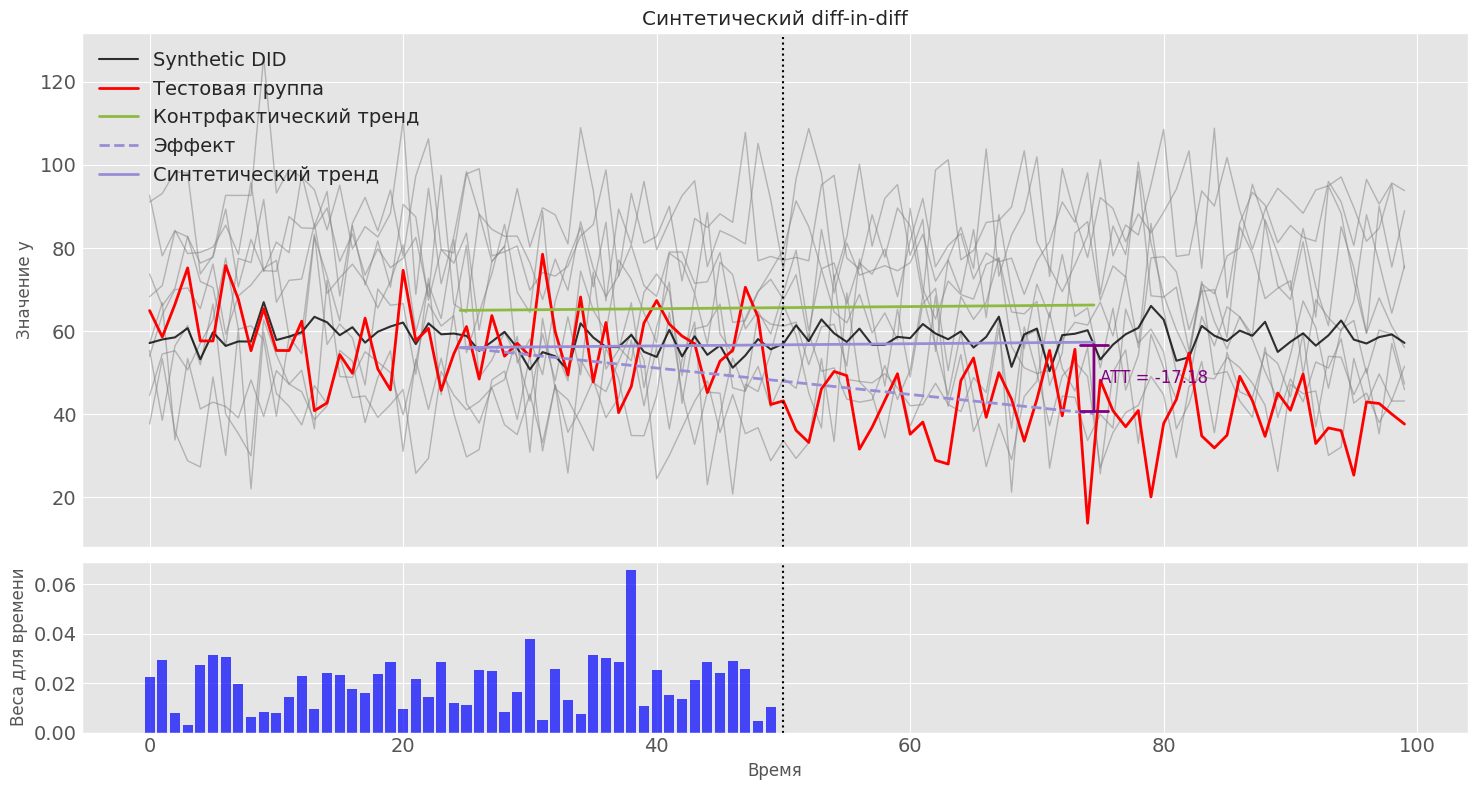

In [76]:
sdid_model = SyntheticDIDModel(
    data=data,
    metric="y",
    period_index="time",
    shopno="unit",
    treated="treated",
    after_treatment="after_treatment"
)

att, unit_weights, time_weights, sdid_model_fit, intercept = sdid_model.synthetic_diff_in_diff()

print("SDID ATT:", round(att, 4))
unit_weights_reset = unit_weights.reset_index().rename(columns={unit_weights.name: "unit_weights", 
                                                                unit_weights.index.name or "unit": "unit"})

print("Веса синтетического контроля:")
for i in range(len(unit_weights_reset)):
    value = unit_weights_reset.loc[i, "unit_weights"]
    if value > 0:
        print(f"Индекс: {unit_weights_reset.loc[i, 'unit']}, Значение: {round(value, 2)}")

sdid_model.plot_synthetic_diff_in_diff(T0=T0)

### Placebo variance estimation and comparison example

$$
\hat{V}^{placebo}_{\tau} = B^{-1}\sum_{b=1}^B\bigg(\hat{\tau}^{(b)} - \bar{\hat{\tau}}^{(b)}\bigg)^2
$$
 
$$
\tau \in \hat{\tau}^{sdid} \pm \mathcal{z}_{\alpha/2} \sqrt{\hat{V}_{\tau}}
$$
 
Код основан на статье: https://matheusfacure.github.io/python-causality-handbook/25-Synthetic-Diff-in-Diff.html#synthetic-controls-revisited

In [7]:
se, ci_low, ci_high = sc_model.estimate_se_sc(alpha=0.05)
print(f"Оценка стандартной ошибки: {round(se, 4)}")
print(f"95% доверительный интервал: [{round(ci_low, 4)}; {round(ci_high, 4)}]")

Оценка стандартной ошибки: 3.1306
95% доверительный интервал: [-24.9854; -12.7138]


In [8]:
att, se, ci_low, ci_high = sdid_model.estimate_se(alpha=0.05)

print(f"Стандартная ошибка: {round(se, 4)}")
print(f"95% доверительный интервал: [{round(ci_low, 4)}; {round(ci_high, 4)}]")

Стандартная ошибка: 1.6996
95% доверительный интервал: [-20.5111; -13.8489]


## Bayesian approach

### Bayesian Synthetic Control example

$$y_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

$$\mu_i = \alpha + \sum_{j=2}^{J + 1} w_j \cdot X_{ij}$$

С априорными распределениями:

$$\alpha \sim \mathcal{N}(0, 1)$$
$$\mathbf{w_J} \sim \text{Dirichlet}(\mathbf{1})$$
$$\sigma \sim \text{HalfNormal}(1)$$

Поскольку веса сгенерированы из распределения Дирихле, эти значения автоматически удовлетворяют следующим условиям:


$$w_j \geq 0, \quad \sum_{j=1}^{J} w_j = 1$$

Код основан на статье: https://causalpy.readthedocs.io/en/stable/notebooks/sc_pymc.html

-----

Примечание: 

В библиотеке *causalpy* при реализации модели синтетического контроля с *"WeightedSumFitter"* возникает ошибка с тем, что константа принимается за вес и ее значение модель пытается привести к ограничениям о том, что она обязана быть неотрицательной и в сумме с весами давать 1, чего не должно происходить. Ниже будет использоваться исправленный класс *"WeightedSumFitter"*

#### Пример реализации на основе causalpy с исправленным *"WeightedSumFitter"*:

In [9]:
result_with_intercept = causalpy.SyntheticControl(
    data_bayes,
    treatment_time = T0,
    formula="actual ~ 1 + a + b + c + d + e + f + g + h + i",
    model=WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

az.summary(result_with_intercept.post_impact.mean("obs_ind"))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, intercept, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-19.195,1.366,-21.81,-16.725,0.022,0.015,4010.0,3770.0,1.0


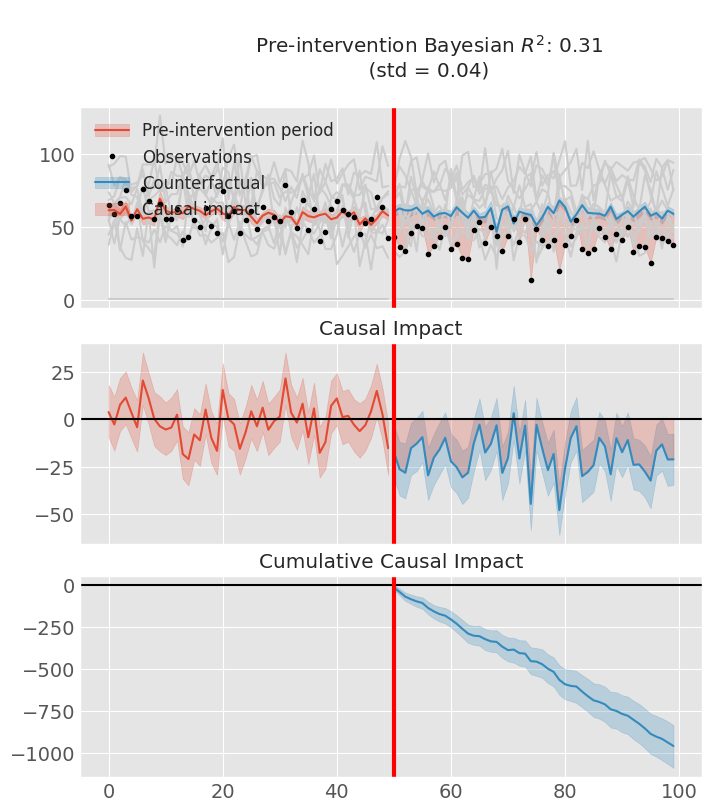

In [10]:
fig, ax = result_with_intercept.plot(plot_predictors=True)

In [11]:
result_with_intercept.print_coefficients()

Model coefficients:
    Intercept  -0.78, 94% HDI [-2.6, 1.1]
    a          0.07, 94% HDI [0.0033, 0.19]
    b          0.15, 94% HDI [0.037, 0.25]
    c          0.032, 94% HDI [0.00092, 0.11]
    d          0.064, 94% HDI [0.0029, 0.17]
    e          0.23, 94% HDI [0.084, 0.37]
    f          0.24, 94% HDI [0.11, 0.37]
    g          0.097, 94% HDI [0.0072, 0.23]
    h          0.053, 94% HDI [0.0026, 0.15]
    i          0.06, 94% HDI [0.0025, 0.18]
    sigma      7.1, 94% HDI [6.3, 7.9]


#### Пример реализации с помощью чистого pymc: 

На основе статьи: https://juanitorduz.github.io/synthetic_control_pymc/

In [55]:
treatment_time = T0

formula = "actual ~ 0 + a + b + c + d + e + f + g + h + i"

datapre = data_bayes[data_bayes.index < treatment_time]
datapost = data_bayes[data_bayes.index >= treatment_time]

y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)

del y, X

In [110]:
def bayesian_synthetic_model(X, y, formula):
    include_intercept = "1" in formula.split("~")[1]

    with pm.Model() as model:
        n_predictors = X.shape[1]

        X_data = pm.MutableData(name="X", value=X)
        y_data = pm.MutableData(name="y", value=y[:, 0])

        if include_intercept:
            intercept = pm.Normal("intercept", mu=0, sigma=1)
            beta = pm.Dirichlet("beta", a=np.ones(n_predictors - 1))

            X_without_intercept = X_data[:, 1:]
            mu = pm.Deterministic("mu", intercept + pm.math.dot(X_without_intercept, beta))
        else:
            beta = pm.Dirichlet("beta", a=np.ones(n_predictors))
            mu = pm.Deterministic("mu", pm.math.dot(X_data, beta))

        sigma = pm.HalfNormal("sigma", 1)
        pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y_data)

    with model:
        idata = pm.sample()
        posterior_predictive_pre = pm.sample_posterior_predictive(trace=idata)

    return idata, posterior_predictive_pre, model

In [137]:
idata, posterior_predictive_pre, model = bayesian_synthetic_model(pre_X, pre_y, formula)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y_hat]


Output()

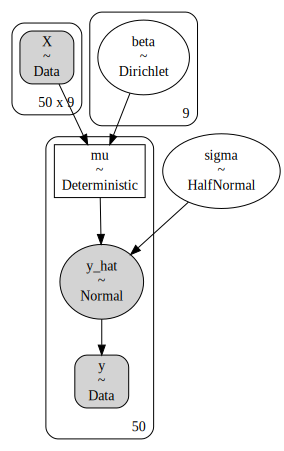

In [80]:
model.to_graphviz()

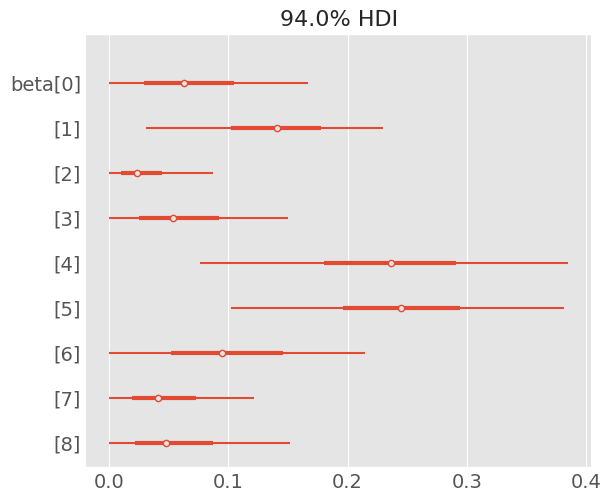

In [81]:
az.plot_forest(data=idata, combined=True, var_names=["beta"]);

In [82]:
with model:
    pm.set_data(new_data={"X": post_X, "y": post_y[:, 0]})
    posterior_predictive_post = pm.sample_posterior_predictive(
        trace=idata, var_names=["y_hat"]
    )

Sampling: [y_hat]


Output()

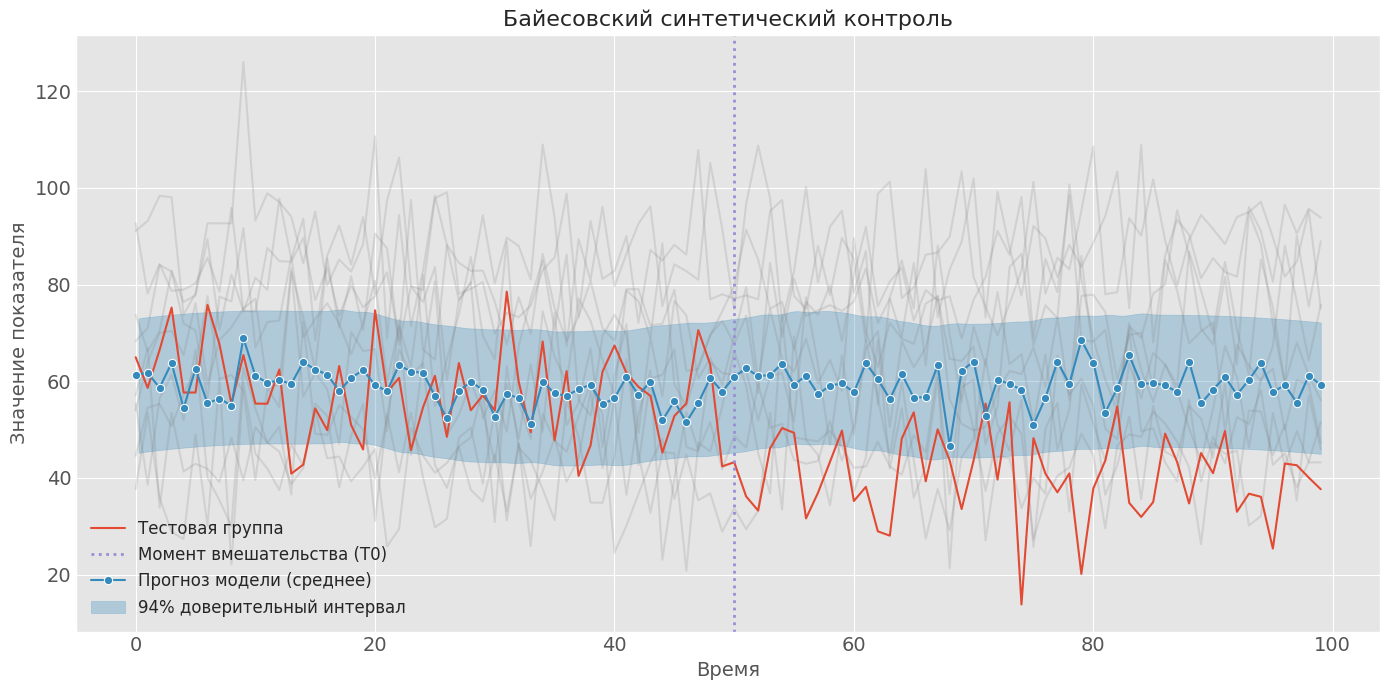

In [83]:
data_bayes_index = data_bayes.reset_index()
data_bayes_index.groupby(["index", "actual"], as_index=False)

pre_posterior_mean = (
    posterior_predictive_pre.posterior_predictive["y_hat"][:, :, :T0]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)

post_posterior_mean = (
    posterior_predictive_post.posterior_predictive["y_hat"][:, :, :T0]
    .stack(samples=("chain", "draw"))
    .mean(axis=1)
)

posterior_mean_full = np.concatenate([pre_posterior_mean, post_posterior_mean])
x_full = list(range(0, T0 + len(post_posterior_mean)))

fig, ax = plt.subplots(figsize=(14, 7))

for col in data_bayes.columns:
    if col != 'actual':
        sns.lineplot(
            x=data_bayes.index,
            y=data_bayes[col],
            color='gray',
            alpha=0.2,
            ax=ax
        )

sns.lineplot(
    x=data_bayes.index,
    y=data_bayes['actual'],
    color='C0',
    label='Тестовая группа',
    ax=ax
)

ax.axvline(
    x=T0,
    linestyle=":",
    lw=2,
    color="C2",
    label="Момент вмешательства (T0)"
)

sns.lineplot(
    x=x_full,
    y=posterior_mean_full,
    color="C1",
    marker="o",
    label="Прогноз модели (среднее)",
    ax=ax,
)

hdi_pre = posterior_predictive_pre.posterior_predictive["y_hat"][:, :, :T0]
hdi_post = posterior_predictive_post.posterior_predictive["y_hat"]
hdi_full = np.concatenate([hdi_pre, hdi_post], axis=2)

az.plot_hdi(
    x=x_full,
    y=hdi_full,
    smooth=True,
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": "94% доверительный интервал"},
    ax=ax,
)

ax.set_title("Байесовский синтетический контроль", fontsize=16)
ax.set_xlabel("Время", fontsize=14)
ax.set_ylabel("Значение показателя", fontsize=14)
ax.legend(loc="lower left", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

### Bayesian R2D2 Synthetic Control example

In [138]:
def bayesian_gp_synthetic_model(t, y, X, use_covariates=True):
    with pm.Model() as model:
        t_shared = pm.MutableData("t", t.reshape(-1, 1))
        
        if use_covariates:
            X_shared = pm.MutableData("X", X)
            beta_lin = pm.Dirichlet("beta_lin", a=np.ones(X.shape[1]))
            intercept = pm.Normal("intercept", mu=0, sigma=5)
            linear_term = intercept + pm.math.dot(X_shared, beta_lin)
        else:
            linear_term = 0
        
        sigma_f = pm.HalfNormal("sigma_f", sigma=2)
        ell = pm.HalfNormal("ell", sigma=2)
        cov_func = sigma_f**2 * pm.gp.cov.ExpQuad(1, ell)
        gp = pm.gp.Latent(cov_func=cov_func)
        gp_effect = gp.prior("gp_effect", X=t_shared)

        mu = pm.Deterministic("mu", linear_term + gp_effect)

        sigma = pm.HalfNormal("sigma", sigma=2)

        y_shared = pm.MutableData("y", y)
        pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y_shared)

        idata = pm.sample(return_inferencedata=True)
        posterior_predictive = pm.sample_posterior_predictive(idata)
        
    return idata, posterior_predictive, model



In [139]:
treatment_time = T0

formula = "actual ~ 0 + a + b + c + d + e + f + g + h + i"

datapre = data_bayes[data_bayes.index < treatment_time]
datapost = data_bayes[data_bayes.index >= treatment_time]

y, X = dmatrices(formula, datapre)

pre_y, pre_X = np.asarray(y), np.asarray(X)


(new_y, new_x) = build_design_matrices(
    [y.design_info, X.design_info], datapost
)
post_X = np.asarray(new_x)
post_y = np.asarray(new_y)

del y, X

y_pre_dm, X_pre_dm = dmatrices(formula, datapre)

design_infos = [y_pre_dm.design_info, X_pre_dm.design_info]

y_pre = np.asarray(y_pre_dm)   
X_pre = np.asarray(X_pre_dm)  


(new_y_dm, new_x_dm) = build_design_matrices(design_infos, datapost)

y_post = np.asarray(new_y_dm)   
X_post = np.asarray(new_x_dm)   


In [140]:
y_pre_model = y_pre.flatten()  

pre_t = np.arange(y_pre_model.shape[0]) 

idata, posterior_predictive_pre, model = bayesian_gp_synthetic_model(pre_t, y_pre_model, X_pre, use_covariates=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_lin, intercept, sigma_f, ell, gp_effect_rotated_, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_hat]


Output()

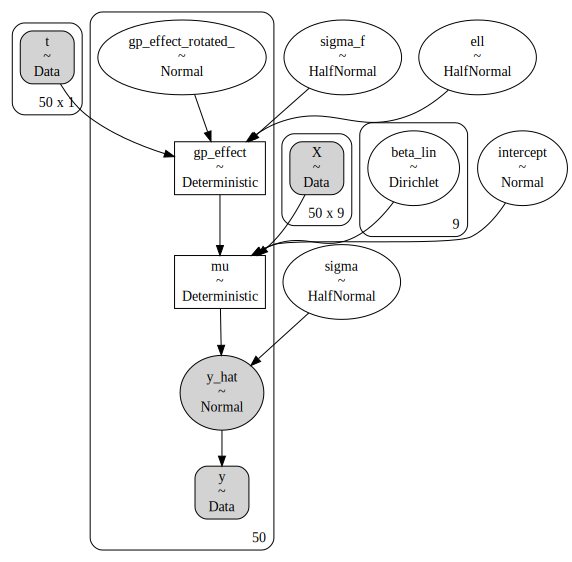

In [141]:
model.to_graphviz()

In [142]:
y_post_model = y_post.flatten()
post_t = np.arange(pre_t[-1] + 1, pre_t[-1] + 1 + y_post_model.shape[0])

In [ ]:
with model:
    pm.set_data(new_data={"t": post_t.reshape(-1, 1), "X": X_post, "y": y_post_model})
    posterior_predictive_post = pm.sample_posterior_predictive(trace=idata, var_names=["y_hat"])


Sampling: [gp_effect_rotated_, y_hat]


Output()

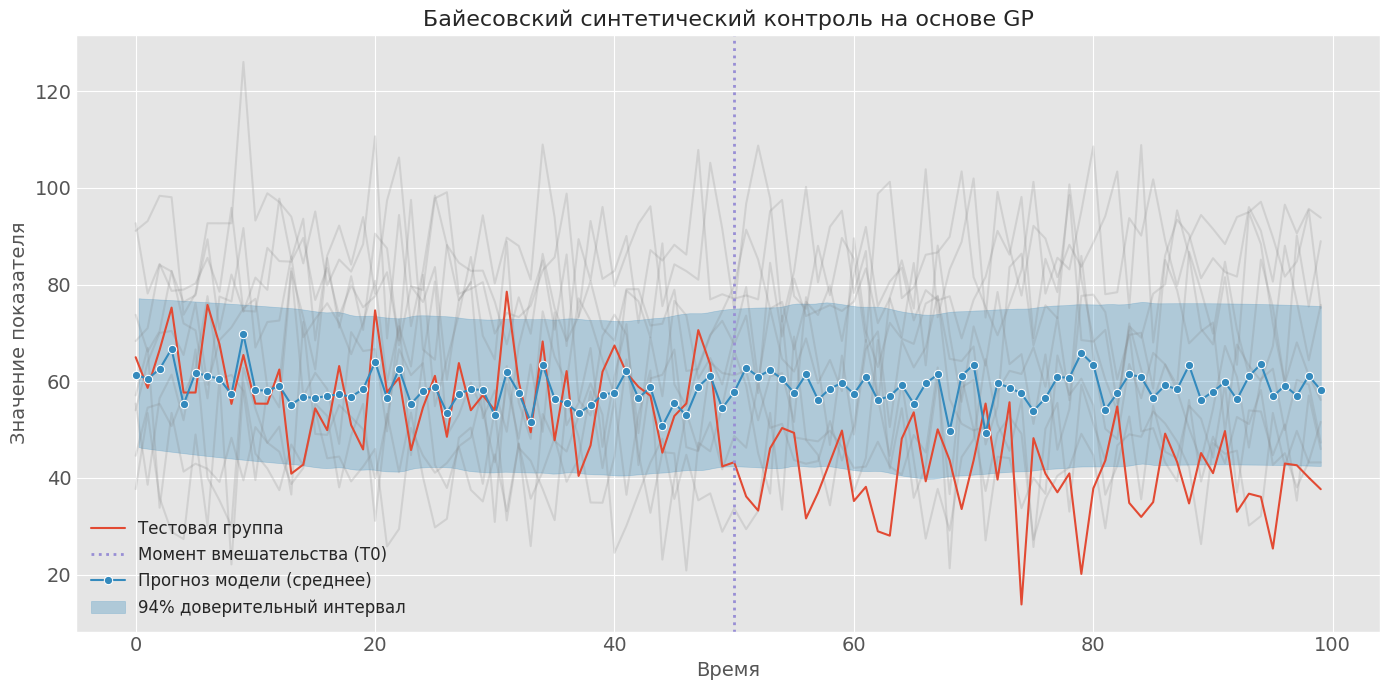

In [ ]:
y_hat_pre = posterior_predictive_pre.posterior_predictive["y_hat"]
y_hat_post = posterior_predictive_post.posterior_predictive["y_hat"]

pre_posterior_mean = y_hat_pre.stack(samples=("chain", "draw")).mean(axis=1).values
post_posterior_mean = y_hat_post.stack(samples=("chain", "draw")).mean(axis=1).values

posterior_mean_full = np.concatenate([pre_posterior_mean, post_posterior_mean])
x_full = np.concatenate([pre_t, post_t])  

fig, ax = plt.subplots(figsize=(14, 7))

for col in data_bayes.columns:
    if col != 'actual':
        sns.lineplot(
            x=data_bayes.index,
            y=data_bayes[col],
            color='gray',
            alpha=0.2,
            ax=ax
        )

sns.lineplot(
    x=data_bayes.index,
    y=data_bayes['actual'],
    color='C0',
    label='Тестовая группа',
    ax=ax
)

ax.axvline(
    x=T0,
    linestyle=":",
    lw=2,
    color="C2",
    label="Момент вмешательства (T0)"
)

sns.lineplot(
    x=x_full,
    y=posterior_mean_full,
    color="C1",
    marker="o",
    label="Прогноз модели (среднее)",
    ax=ax,
)

if y_hat_pre.ndim == 3:
    hdi_pre = y_hat_pre  
else:
    hdi_pre = y_hat_pre  

if y_hat_post.ndim == 3:
    hdi_post = y_hat_post  
    hdi_post = y_hat_post

hdi_full = np.concatenate([hdi_pre, hdi_post], axis=-1)
az.plot_hdi(
    x=x_full,
    y=hdi_full,
    smooth=True,
    color="C1",
    fill_kwargs={"alpha": 0.3, "label": "94% доверительный интервал"},
    ax=ax,
)

ax.set_title("Байесовский синтетический контроль на основе GP", fontsize=16)
ax.set_xlabel("Время", fontsize=14)
ax.set_ylabel("Значение показателя", fontsize=14)
ax.legend(loc="lower left", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

In [145]:
actual_post = data_bayes.loc[datapost.index, "actual"].values


att_time_series = actual_post - post_posterior_mean

att_mean = np.mean(att_time_series)

print("Эффект воздействия для каждой временной точки (ATT):", att_time_series)
print("Средний эффект воздействия (ATT): {:.3f}".format(att_mean))


Эффект воздействия для каждой временной точки (ATT): [-14.52894026 -26.64883598 -27.71816961 -16.15811434 -10.13588141
  -8.28037534 -29.7876455  -19.26903018 -15.13301206  -9.91248291
 -22.16044641 -22.78420099 -27.20138832 -28.86926691 -11.09444288
  -1.7939466  -20.25596214 -11.36430478  -6.15200246 -27.57701452
 -19.81284354   6.10215208 -19.95065388  -3.01808837 -43.65916421
  -5.62558623 -15.62411471 -23.81905564 -19.81569775 -45.71841574
 -25.63618389 -10.53157041  -2.74716466 -26.62314129 -28.92404858
 -21.62504865  -9.99761244 -15.04146734 -28.60022248 -11.02612168
 -16.86953809 -10.13828089 -23.2361276  -24.27962438 -27.46019287
 -31.47921699 -16.12865564 -14.41433437 -21.07996001 -20.49782456]
Средний эффект воздействия (ATT): -18.682


In [150]:
actual_post + 20

array([63.24083969, 56.1491772 , 53.23078   , 66.11676289, 70.30999522,
       69.31280119, 51.60782477, 56.90787624, 63.31263431, 69.75545127,
       55.20825762, 58.14341023, 48.93665026, 48.03793376, 68.12525822,
       73.56240028, 59.27989878, 70.03532898, 63.61636025, 53.54880245,
       63.61395605, 75.38036566, 59.64173961, 75.64643656, 33.80254896,
       68.21902504, 60.87047068, 57.0099265 , 60.91760777, 40.12431086,
       57.80328112, 63.57112571, 74.77894045, 54.81729782, 51.91506397,
       54.98242956, 69.15402118, 63.2875111 , 54.70239796, 65.13267433,
       60.97077549, 69.6864499 , 52.97946906, 56.72337853, 56.07891847,
       45.36485052, 62.96120277, 62.61055272, 60.05113457, 57.65412867])

In [149]:
post_posterior_mean

array([57.76977995, 62.79801318, 60.9489496 , 62.27487723, 60.44587664,
       57.59317653, 61.39547027, 56.17690642, 58.44564637, 59.66793418,
       57.36870404, 60.92761123, 56.13803858, 56.90720067, 59.2197011 ,
       55.35634689, 59.53586092, 61.39963375, 49.76836271, 61.12581698,
       63.4267996 , 49.27821358, 59.59239349, 58.66452493, 57.46171317,
       53.84461127, 56.49458539, 60.82898213, 60.73330552, 65.8427266 ,
       63.43946501, 54.10269613, 57.52610511, 61.4404391 , 60.83911255,
       56.60747822, 59.15163362, 58.32897844, 63.30262044, 56.15879601,
       57.84031358, 59.82473079, 56.21559666, 61.00300291, 63.53911134,
       56.84406751, 59.08985841, 57.02488709, 61.13109458, 58.15195323])